In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import animation
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict, Iterable, Optional, Tuple, Set


# Parámetros

In [2]:
# Constantes globales (usadas en bloques siguientes)
VMAX = 1.0   # velocidad máxima (mochila vacía)
VMIN = 0.1   # velocidad mínima (mochila llena)
WMAX = 50.0  # peso máximo de la mochila
NOBJ = 100   # número de objetos
n = 8        # número de ciudades
start = 1    # ciudad de inicio
R = 1       # Ratio de beneficio/costo

# Crear Grafo

In [3]:
def crear_kn_distancias(
    n: int,
    dibujar: bool = True,
    layout: str = "circular",
    seed: int = 42,
    aleatorio: bool = True,
    min_dist: float = 1.0,
    max_dist: float = 10.0,
    matriz_distancias: np.ndarray | None = None,
):
    """
    Crea un grafo completo K_n (2 ≤ n ≤ 8).

    - Si matriz_distancias no es None, la usa tal cual (se asume cuadrada n×n).
    - Si matriz_distancias es None y aleatorio=True, genera distancias aleatorias
      simétricas en [min_dist, max_dist].
    - Si aleatorio=False, todas las distancias son 1 (versión antigua).

    Devuelve:
      - distances: matriz numpy (n x n) con 0 en diagonal
      - G: networkx.Graph con pesos 'weight' = distances[u,v]
    """
    if not (2 <= n <= 8):
        raise ValueError("n debe estar entre 2 y 8 (K_8 como máximo).")

    # --- Construir matriz de distancias ---
    if matriz_distancias is not None:
        distances = np.array(matriz_distancias, dtype=float)
        if distances.shape != (n, n):
            raise ValueError("matriz_distancias debe ser de tamaño (n, n)")
        # Asegurar diagonal 0
        np.fill_diagonal(distances, 0.0)
    else:
        if aleatorio:
            rng = np.random.default_rng(seed)
            distances = rng.uniform(min_dist, max_dist, size=(n, n))
            # Hacerla simétrica
            distances = (distances + distances.T) / 2.0
            np.fill_diagonal(distances, 0.0)
        else:
            distances = np.ones((n, n), dtype=float)
            np.fill_diagonal(distances, 0.0)

    # --- Grafo completo con esos pesos ---
    G = nx.complete_graph(n)
    for u, v in G.edges():
        G[u][v]['weight'] = float(distances[u, v])

    # --- Dibujo opcional ---
    if dibujar:
        if layout == "spring":
            pos = nx.spring_layout(G, seed=seed)
        elif layout == "kamada":
            pos = nx.kamada_kawai_layout(G)
        else:
            pos = nx.circular_layout(G)

        plt.figure(figsize=(4, 4))
        nx.draw(
            G, pos,
            with_labels=True,
            node_size=800,
            node_color="#93c5fd",
            edgecolors="#1f2937",
            linewidths=1.5,
            width=1.5,
        )

        # Etiquetas con las distancias
        edge_labels = {
            (u, v): f"{G[u][v]['weight']:.1f}" for u, v in G.edges()
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        plt.title(f"Grafo completo K_{n}", fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    return distances, G


def imprimir_matriz_numpy(dist):
    """Imprime la matriz de distancias en formato legible."""
    n = dist.shape[0]
    for i in range(n):
        fila = " ".join(f"{dist[i,j]:4.1f}" for j in range(n))
        print(f"[{i:02d}] {fila}")



C:\Users\crist\AppData\Local\Temp\ipykernel_20304\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


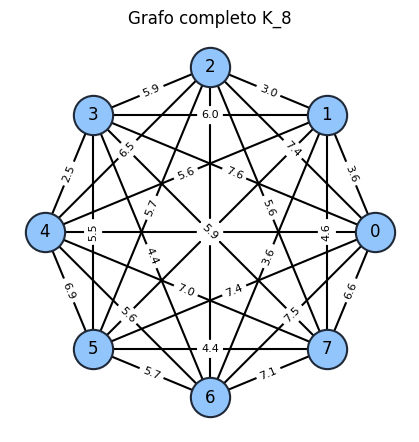

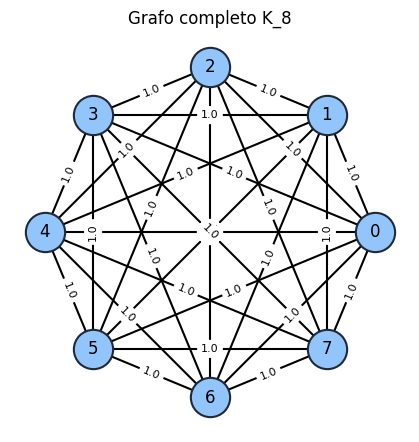

In [4]:
# Grafo con distancias aleatorias entre 1 y 20
distances, G = crear_kn_distancias(n, aleatorio=True, min_dist=1.0, max_dist=10.0)

# Grafo con TODAS las distancias = 1 (comportamiento viejo)
distances, G = crear_kn_distancias(n, aleatorio=False)

# Grafo usando una matriz que la persona mismo diseñó
mi_matriz = np.array([
    [0, 5, 2],
    [5, 0, 7],
    [2, 7, 0],
], dtype=float)

# Crear Objetos

In [5]:
@dataclass
class Item:
    id: int
    city: int
    value: float
    weight: float
    name: str = ""   # nuevo campo opcional



def generar_items(
    n_ciudades: int,
    m_items: int,
    valor_min: int = 10,
    valor_max: int = 100,
    peso_min: int = 1,
    peso_max: int = 100,
    asegurar_uno_por_ciudad: bool = True,
    seed: Optional[int] = None,
    name_prefix: Optional[str] = "Item",      # nuevo: prefijo para nombres
    names: Optional[Iterable[str]] = None     # nuevo: lista de nombres exacta (opcional)
) -> List[Item]:
    """
    Genera 'm_items' con (id, city, value, weight).
    - Si asegurar_uno_por_ciudad=True y m_items >= n_ciudades, garantiza ≥1 ítem por ciudad.
    - 'seed' permite reproducibilidad.
    """
    if seed is not None:
        random.seed(seed)

    items: List[Item] = []
    next_id = 0

    # helper para obtener nombre
    def _make_name(id):
        if names is not None:
            try:
                return list(names)[id]
            except Exception:
                return f"{name_prefix}{id}"
        return f"{name_prefix}{id}"

    # asegurar al menos uno por ciudad
    if asegurar_uno_por_ciudad and m_items >= n_ciudades:
        for c in range(n_ciudades):
            value = random.randint(valor_min, valor_max)
            weight = random.randint(peso_min, peso_max)
            items.append(Item(id=next_id, city=c, value=value, weight=weight, name=_make_name(next_id)))
            next_id += 1

    # completar hasta m_items
    while next_id < m_items:
        c = random.randrange(n_ciudades)
        value = random.randint(valor_min, valor_max)
        weight = random.randint(peso_min, peso_max)
        items.append(Item(id=next_id, city=c, value=value, weight=weight, name=_make_name(next_id)))
        next_id += 1

    return items

def items_por_ciudad(items: List[Item]) -> Dict[int, List[Item]]:
    """Agrupa ítems por ciudad: {city: [Item, ...]}."""
    bolsa: Dict[int, List[Item]] = {}
    for it in items:
        bolsa.setdefault(it.city, []).append(it)
    return bolsa

def imprimir_items(items: List[Item]) -> None:
    for it in items:
        nm = f" name={it.name}" if it.name else ""
        print(f"[Item {it.id:02d}]{nm}  ciudad={it.city}  valor={it.value}  peso={it.weight}")

In [6]:
items_Test = [
    Item(id=0, city=0, value=5000,   weight=10.0,  name="Rolex"),
    Item(id=1, city=1, value=6000,   weight=100.0, name="CajaFuerte"),
    Item(id=2, city=0, value=5,      weight=4.0,  name="Manzana"),
    Item(id=3, city=2, value=700,    weight=90.0,  name="Televisor"),
    Item(id=4, city=3, value=12000,  weight=2.0,  name="Diamante"),
    Item(id=5, city=4, value=30,     weight=12.0,  name="Libro"),
    Item(id=6, city=2, value=900,    weight=40.0,  name="Cámara"),
    Item(id=7, city=7, value=1500,   weight=60.0,  name="Laptop"),
    Item(id=8, city=6, value=300,    weight=1.0, name="MonedaAntigua"),
    Item(id=9, city=4, value=2500,   weight=10.0,  name="CollarPerlas"),
    Item(id=10, city=3, value=4000,  weight=25.0,  name="PinturaValiosa"),
    Item(id=11, city=5, value=500,   weight=5.0,  name="Celular"),
    Item(id=12, city=6, value=100,   weight=2.0,  name="Billetera"),
]

C:\Users\crist\AppData\Local\Temp\ipykernel_20304\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


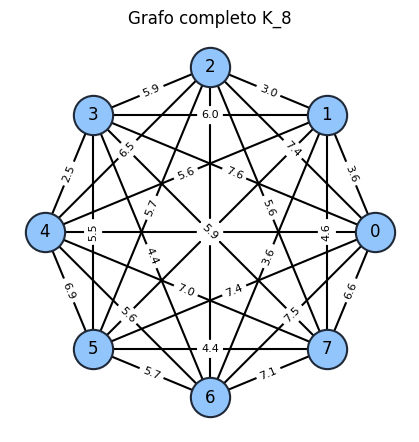


Ítems generados (online: el ladrón conoce todos):
[Item 00] name=Rolex  ciudad=0  valor=5000  peso=10.0
[Item 01] name=CajaFuerte  ciudad=1  valor=6000  peso=100.0
[Item 02] name=Manzana  ciudad=0  valor=5  peso=4.0
[Item 03] name=Televisor  ciudad=2  valor=700  peso=90.0
[Item 04] name=Diamante  ciudad=3  valor=12000  peso=2.0
[Item 05] name=Libro  ciudad=4  valor=30  peso=12.0
[Item 06] name=Cámara  ciudad=2  valor=900  peso=40.0
[Item 07] name=Laptop  ciudad=7  valor=1500  peso=60.0
[Item 08] name=MonedaAntigua  ciudad=6  valor=300  peso=1.0
[Item 09] name=CollarPerlas  ciudad=4  valor=2500  peso=10.0
[Item 10] name=PinturaValiosa  ciudad=3  valor=4000  peso=25.0
[Item 11] name=Celular  ciudad=5  valor=500  peso=5.0
[Item 12] name=Billetera  ciudad=6  valor=100  peso=2.0

Resumen por ciudad:
Ciudad 0: 2 ítems
Ciudad 1: 1 ítems
Ciudad 2: 2 ítems
Ciudad 3: 2 ítems
Ciudad 4: 2 ítems
Ciudad 5: 1 ítems
Ciudad 6: 2 ítems
Ciudad 7: 1 ítems


In [7]:
# --- Ejemplo mínimo de uso del Bloque 2 ---
distances, G = crear_kn_distancias(n)

# Generar 12 ítems con reproducibilidad
items = generar_items(n_ciudades=n, m_items=12, seed=42)

print("\nÍtems generados (online: el ladrón conoce todos):")
imprimir_items(items_Test)

# Resumen por ciudad
por_ciudad = items_por_ciudad(items_Test)
print("\nResumen por ciudad:")
for c in range(n):
    print(f"Ciudad {c}: {len(por_ciudad.get(c, []))} ítems")

#Configuración de la velocidad

In [8]:
def velocidad_por_peso(Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Velocidad lineal del TTP:
        v = vmax - (Wc / W_max) * (vmax - vmin)
    Restringe la fracción a [0,1] para evitar valores fuera de rango.
    """
    if W_max <= 0:
        raise ValueError("WMAX debe ser > 0")
    frac = Wc / W_max
    if frac < 0:   frac = 0.0
    if frac > 1:   frac = 1.0
    return vmax - frac * (vmax - vmin)

def tiempo_de_tramo(distancia, Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Tiempo = distancia / velocidad_actual.
    """
    v = velocidad_por_peso(Wc, W_max, vmax, vmin)
    if v <= 0:
        raise ValueError("La velocidad debe ser positiva.")
    return distancia / v

def tiempo_total_tour(distances, tour, Wc_constante, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Calcula el tiempo total de un tour circular usando un Wc fijo en todo el recorrido.
    Esto sirve solo para probar el efecto del peso en los tiempos.
    """
    n = len(tour)
    total = 0.0
    for i in range(n):
        a = tour[i]
        b = tour[(i+1) % n]
        d = distances[a, b]
        total += tiempo_de_tramo(d, Wc_constante, W_max, vmax, vmin)
    return total

def tiempo_total_tour_con_evolucion(distances, tour, perfil_Wc, W_max=WMAX, vmax=VMAX, vmin=VMIN):
    """
    Variante donde se entrega un perfil de pesos Wc (peso que lleva ANTES de cada tramo).
    perfil_Wc debe tener la misma longitud que tour.
    """
    if len(perfil_Wc) != len(tour):
        raise ValueError("perfil_Wc debe tener la misma longitud que tour.")
    n = len(tour)
    total = 0.0
    for i in range(n):
        a = tour[i]
        b = tour[(i+1) % n]
        d = distances[a, b]
        total += tiempo_de_tramo(d, perfil_Wc[i], W_max, vmax, vmin)
    return total

C:\Users\crist\AppData\Local\Temp\ipykernel_20304\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


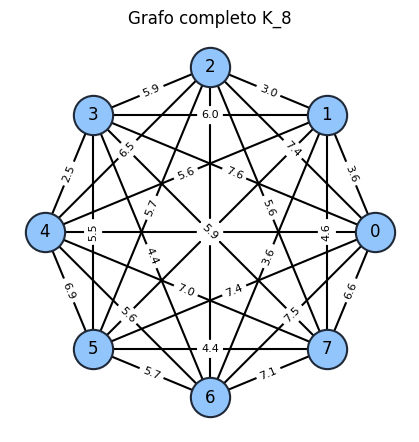

Tiempo tour con Wc=0 (v≈1.0): 41.2775
Tiempo tour con Wc=W_max (v≈0.1): 412.7747
Tiempo tour con perfil creciente Wc: 146.2232


In [9]:
# --- Ejemplo mínimo de uso del Bloque 3 ---
distances, _ = crear_kn_distancias(n)
tour = list(range(n))  # 0->1->2->3->4->0

# (A) Tiempo con mochila vacía todo el tour
t_vacio = tiempo_total_tour(distances, tour, Wc_constante=0.0)
print(f"Tiempo tour con Wc=0 (v≈{VMAX}): {t_vacio:.4f}")

# (B) Tiempo con mochila llena todo el tour
t_lleno = tiempo_total_tour(distances, tour, Wc_constante=WMAX)
print(f"Tiempo tour con Wc=W_max (v≈{VMIN}): {t_lleno:.4f}")
# (C) Tiempo con perfil creciente de peso (ejemplo sintético)
#    Nota: más adelante este perfil saldrá del picking real.
perfil = np.linspace(0, WMAX, num=len(tour))  # arranca vacío y termina lleno
t_perfil = tiempo_total_tour_con_evolucion(distances, tour, perfil)
print(f"Tiempo tour con perfil creciente Wc: {t_perfil:.4f}")

# Items por Ciudad

In [10]:
def agrupar_items_por_ciudad(items: List[Item]) -> Dict[int, List[Item]]:
    """Devuelve {ciudad: [Item,...]}"""
    bolsa: Dict[int, List[Item]] = {}
    for it in items:
        bolsa.setdefault(it.city, []).append(it)
    return bolsa


In [11]:
# --- Evaluador principal ---

def evaluar_ttp1(
    distances: np.ndarray,
    tour: list[int],
    items,
    W_max: float,
    R: float,
    picking_policy: str = "greedy",
    v_max: float = 1.0,
    v_min: float = 0.1,
):
    """
    Evalúa un tour para el problema TTP1.

    distances : matriz de distancias (n x n)
    tour      : lista de ciudades en el orden en que se visitan
    items     : lista de ítems; se asume que cada ítem tiene
                .city, .value, .weight, .id   (adaptar nombres si hace falta)
    W_max     : capacidad máxima de la mochila
    R         : factor de alquiler (rent rate) del paper
    picking_policy : "all", "greedy" o "exchange"
                     (también acepta "ttp1" como alias de "greedy")
    v_max, v_min   : velocidades máxima y mínima (TTP1)

    Devuelve un dict con:
        - total_value
        - total_time
        - final_benefit = total_value - R * total_time
        - pickup_log    : [(ciudad, [ids_tomados_en_esa_ciudad]), ...]
        - knapsack_log  : [(ciudad, [ids_en_mochila_despues_de_la_ciudad]), ...]
    """

    # ---------------------------------------------------------
    # 0. Preprocesar ítems por ciudad
    # ---------------------------------------------------------
    
    items_por_ciudad = defaultdict(list)
    for it in items:
        # adaptar aquí si el nombre de los atributos es distinto
        items_por_ciudad[it.city].append(it)

    # ---------------------------------------------------------
    # 1. Estado inicial
    # ---------------------------------------------------------
    mochila = []          # lista de objetos ítem
    peso_actual = 0.0
    total_value = 0.0
    total_time = 0.0

    pickup_log = []    # qué se tomó en cada ciudad
    knapsack_log = []  # contenido de mochila después de cada ciudad

    n = len(tour)

    def ratio(item):
       return item.value / item.weight

    # ---------------------------------------------------------
    # 2. Recorrer el tour
    # ---------------------------------------------------------
    for k, ciudad in enumerate(tour):

        disponibles = items_por_ciudad.get(ciudad, [])
        tomados_ahora = []


        # ---------------------------------------------
        # 2.a Escoger ítems según la política
        # ---------------------------------------------
        if picking_policy == "all":
            # Tomar todo lo que quepa
            for it in disponibles:
                if peso_actual + it.weight <= W_max:
                    mochila.append(it)
                    print("La mochila tiene ahora (ALL):", [(it_m.id, it_m.weight) for it_m in mochila])
                    peso_actual += it.weight
                    total_value += it.value
                    tomados_ahora.append(it.id)  # adaptar si el atributo se llama distinto

        elif picking_policy in ("greedy", "exchange"):
            # Ordenar por ratio valor/peso (como en el paper)
            candidatos = sorted(
                disponibles,
                key=ratio,
                reverse=True,
            )

            if picking_policy == "greedy":
                # Simplemente intentar meterlos en orden
                for it in candidatos:
                    if peso_actual + it.weight <= W_max:
                        mochila.append(it)
                        print("La mochila tiene ahora (GREEDY):", [(it_m.id, it_m.weight) for it_m in mochila])
                        peso_actual += it.weight
                        total_value += it.value
                        tomados_ahora.append(it.id)

            elif  picking_policy == "exchange":
                # Greedy + intercambios inteligentes 1-a-1
                for nuevo in candidatos:
                    # Si ya está en la mochila, ignorar
                    if nuevo in mochila:
                        continue

                    # 1) Intento directo
                    if peso_actual + nuevo.weight <= W_max:
                        mochila.append(nuevo)
                        print("La mochila tiene ahora (EXCHANGE):", [(it_m.id, it_m.weight) for it_m in mochila])
                        peso_actual += nuevo.weight
                        total_value += nuevo.value
                        tomados_ahora.append(nuevo.id)
                        print("El peso actual es ahora:", peso_actual)
                        continue

                    # 2) Intento de intercambio 1-a-1:
                    #    buscar el ítem "antiguo" que, al cambiarlo por 'nuevo',
                    #    deje el peso <= W_max y mejore el valor total.
                    mejor_swap = None
                    mejor_ganancia_valor = 0.0

                    for viejo in mochila:
                        peso_nuevo = peso_actual - viejo.weight + nuevo.weight
                        if peso_nuevo <= W_max:
                            ganancia_valor = nuevo.value - viejo.value
                            if ganancia_valor > mejor_ganancia_valor:
                                mejor_ganancia_valor = ganancia_valor
                                mejor_swap = viejo

                    # Si se encontró un intercambio beneficioso, aplicarlo
                    if mejor_swap is not None and mejor_ganancia_valor > 0:
                        print("Hay intercambio positivo:", mejor_swap.id, "por", nuevo.id)
                        
                        mochila.remove(mejor_swap)
                        mochila.append(nuevo)

                        peso_actual = peso_actual - mejor_swap.weight + nuevo.weight
                        total_value += mejor_ganancia_valor

                        tomados_ahora.append(nuevo.id)
                    else:
                        print("Hay intercambio negativo o nulo.")

        else:
            raise ValueError(f"Política de picking desconocida: {picking_policy!r}")

        # Guardar logs de esta ciudad
        pickup_log.append((ciudad, tomados_ahora))
        knapsack_log.append(
            (ciudad, sorted(it.id for it in mochila))
        )
        
        

        # ---------------------------------------------
        # 2.b Viajar a la siguiente ciudad (TTP1)
        # ---------------------------------------------
        siguiente = tour[(k + 1) % n]   # se asume tour cíclico
        distancia = distances[ciudad, siguiente]
        v = velocidad_por_peso(peso_actual, W_max=W_max, vmax=v_max, vmin=v_min)
        total_time += distancia / v

    # ---------------------------------------------------------
    # 3. Beneficio final TTP1
    # ---------------------------------------------------------
    final_benefit = total_value - R * total_time

    return {
        "total_value": total_value,
        "total_time": total_time,
        "final_benefit": final_benefit,
        "pickup_log": pickup_log,
        "knapsack_log": knapsack_log,
    }


C:\Users\crist\AppData\Local\Temp\ipykernel_20304\1060348279.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


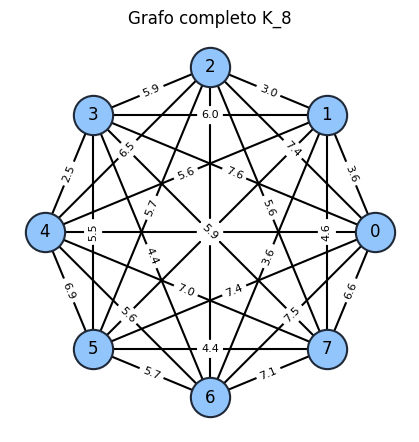

La mochila tiene ahora (ALL): [(8, 1.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0), (5, 12.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0), (5, 12.0), (9, 10.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0), (5, 12.0), (9, 10.0), (4, 2.0)]
La mochila tiene ahora (ALL): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0), (5, 12.0), (9, 10.0), (4, 2.0), (11, 5.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0), (12, 2.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0), (12, 2.0), (0, 10.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0), (12, 2.0), (0, 10.0), (2, 4.0), (9, 10.0)]
La mochila tiene ahora (GREEDY): [(8, 1.0),

In [12]:
# 1) Instancia pequeña
distances, _ = crear_kn_distancias(n)  # K_n
tour = list(range(n))                  # tour circular 0-1-2-3-4-5-6-7-8-0
random.shuffle(tour)

# 2) Evaluar políticas
res_all = evaluar_ttp1(distances, tour, items_Test, WMAX, R, picking_policy="all")
res_grd = evaluar_ttp1(distances, tour, items_Test, WMAX, R, picking_policy="greedy")
res_exch = evaluar_ttp1(distances, tour, items_Test, WMAX, R, picking_policy="exchange")

print("Capacidad mochila =", WMAX)
print("Tour:", tour)
print("\n--- Política: ALL (tomar todo si cabe) ---")
print("Valor total  :", res_all['total_value'])
print("Tiempo total :", res_all['total_time'])
print("Beneficio    :", res_all['final_benefit'])
print("Log picking  :", res_all['pickup_log'])
print("Log mochila  :", res_all['knapsack_log'][-1][1])

print("\n--- Política: GREEDY (por valor/peso) ---")
print("Valor total  :", res_grd['total_value'])
print("Tiempo total :", res_grd['total_time'])
print("Beneficio    :", res_grd['final_benefit'])
print("Log picking  :", res_grd['pickup_log'])
print("Log mochila  :", res_grd['knapsack_log'][-1][1])

print("\n--- Política: EXCHANGE (intercambios) ---")
print("Valor total  :", res_exch['total_value'])
print("Tiempo total :", res_exch['total_time'])
print("Beneficio    :", res_exch['final_benefit']) 
print("Log picking  :", res_exch['pickup_log'])
print("Log mochila  :", res_exch['knapsack_log'][-1][1])

# Generar los Tours

In [13]:
def generar_tours(n: int, start: int = 0):
    """
    Genera todos los tours posibles que:
    - empiezan en 'start'
    - visitan cada ciudad exactamente una vez
    - vuelven implícitamente a 'start' (eso ya lo hace evaluar_ttp)
    Ejemplo para n=4, start=0:
      [0,1,2,3], [0,1,3,2], [0,2,1,3], ...
    """
    otras = [i for i in range(n) if i != start]
    for perm in itertools.permutations(otras):
        yield [start] + list(perm)

def tour_trivial(n: int, start: int = 0) -> List[int]:
    """
    Tour que recorre las ciudades en orden, partiendo en 'start'.
    Ej: n=5, start=0 -> [0,1,2,3,4]
        n=5, start=2 -> [2,3,4,0,1]
    """
    return [(start + i) % n for i in range(n)]

def tour_aleatorio(n: int, start: int = 0, seed: int | None = None) -> List[int]:
    """
    Genera un tour aleatorio que comienza en 'start'.
    """
    rng = np.random.default_rng(seed)
    otras = [i for i in range(n) if i != start]
    rng.shuffle(otras)
    return [start] + otras

def tour_vecino_mas_cercano(distances: np.ndarray, start: int = 0) -> List[int]:
    """
    Construye un tour usando la heurística de vecino más cercano.
    NO es óptimo en general, pero es rápido y da un buen punto de partida.
    """
    n = distances.shape[0]
    no_visitadas = set(range(n))
    no_visitadas.remove(start)
    tour = [start]
    actual = start

    while no_visitadas:
        siguiente = min(no_visitadas, key=lambda j: distances[actual, j])
        no_visitadas.remove(siguiente)
        tour.append(siguiente)
        actual = siguiente

    return tour

def mejor_tour_ttp1(
    distances: np.ndarray,
    items: list[Item],
    W_max: float,
    R: float,
    picking_policy: str = "ttp1",
    start: int = 0,
):
    """
    Busca el mejor tour para el TTP, probando todos los tours que empiezan en 'start'.

    Usa la función evaluar_ttp(distances, tour, items, W_max, R, picking_policy)
    que ya está implementada.

    Devuelve:
      - best_tour: lista de ciudades en orden
      - best_eval: dict con total_value, total_time, final_benefit, etc.
    """
    n = distances.shape[0]
    best_tour = None
    best_eval = None

    for tour in generar_tours(n, start=start):
        res = evaluar_ttp1(distances, tour, items, W_max, R, picking_policy=picking_policy)
        if (best_eval is None) or (res["final_benefit"] > best_eval["final_benefit"]):
            best_eval = res
            best_tour = tour

    return best_tour, best_eval


# Verficación de los Tours

In [14]:
def evaluar_tour(
    distances: np.ndarray,
    tour: List[int],
    items,
    W_max: float,
    R: float,
    picking_policy: str = "greedy",
):
    """
    Envuelve evaluar_ttp para un solo tour.
    """
    return evaluar_ttp1(distances, tour, items, W_max, R, picking_policy=picking_policy)

tour_tri = tour_trivial(n, start=start)
tour_rand = tour_aleatorio(n, start=start, seed=123)
tour_nn  = tour_vecino_mas_cercano(distances, start=start)
tour_opt, eval_opt_greedy = mejor_tour_ttp1(distances, items, WMAX, R, picking_policy="greedy", start=start)

eval_tri_greedy  = evaluar_tour(distances, tour_tri,  items, WMAX, R, picking_policy="greedy")
eval_rand_greedy = evaluar_tour(distances, tour_rand, items, WMAX, R, picking_policy="greedy")
eval_nn_greedy   = evaluar_tour(distances, tour_nn,   items, WMAX, R, picking_policy="greedy")


print("\n--- Comparación de tours ---")
print("\n--- Política: Greedy (tomar todo si cabe) ---")

print("-----------------------------")

print("Tour Creciente:", tour_tri)
print("Valor total Creciente:", eval_tri_greedy['total_value'])
print("Tiempo total Creciente:", eval_tri_greedy['total_time'])
print("Beneficio Creciente:", eval_tri_greedy['final_benefit'])
print("Log picking Creciente:", eval_tri_greedy['pickup_log'])
print("Historial mochila Creciente:", eval_tri_greedy['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Aleatorio:", tour_rand)
print("Valor total Aleatorio:", eval_rand_greedy['total_value'])
print("Tiempo total Aleatorio:", eval_rand_greedy['total_time'])
print("Beneficio Aleatorio:", eval_rand_greedy['final_benefit'])
print("Log picking Aleatorio:", eval_rand_greedy['pickup_log'])
print("Historial mochila Aleatorio:", eval_rand_greedy['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Vecino Más Cercano:", tour_nn)
print("Valor total Vecino Más Cercano:", eval_nn_greedy['total_value'])
print("Tiempo total Vecino Más Cercano:", eval_nn_greedy['total_time'])
print("Beneficio Vecino Más Cercano:", eval_nn_greedy['final_benefit'])
print("Log picking Vecino Más Cercano:", eval_nn_greedy['pickup_log'])
print("Historial mochila Vecino Más Cercano:", eval_nn_greedy['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Óptimo:", tour_opt)
print("Valor total Óptimo:", eval_opt_greedy['total_value'])
print("Tiempo total Óptimo:", eval_opt_greedy['total_time'])
print("Beneficio Óptimo:", eval_opt_greedy['final_benefit'])
print("Log picking Óptimo:", eval_opt_greedy['pickup_log'])
print("Historial mochila Óptimo:", eval_opt_greedy['knapsack_log'][-1][1])

print("-----------------------------")

La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15)]
La mochila tiene ahora (GREEDY): [(8, 30), (0, 15), (7, 4)]
La mochila tiene ahora (GREEDY): [(8, 30)]
La mochila tiene ahora (GRE

In [15]:
eval_opt_exchange = evaluar_tour(distances, tour_opt, items, WMAX, R, picking_policy="exchange")
eval_nn_exchange  = evaluar_tour(distances, tour_nn,   items, WMAX, R, picking_policy="exchange")
eval_rand_exchange = evaluar_tour(distances, tour_rand, items, WMAX, R, picking_policy="exchange")
eval_tri_exchange = evaluar_tour(distances, tour_tri,  items, WMAX, R, picking_policy="exchange")

print("\n--- Política: Exchange (intercambios inteligentes) ---")
print("-----------------------------")

print("Tour Óptimo:", tour_opt)
print("Valor total Óptimo:", eval_opt_exchange['total_value'])
print("Tiempo total Óptimo:", eval_opt_exchange['total_time'])
print("Beneficio Óptimo:", eval_opt_exchange['final_benefit'])
print("Log picking Óptimo:", eval_opt_exchange['pickup_log'])
print("Historial mochila Óptimo:", eval_opt_exchange['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Vecino Más Cercano:", tour_nn)
print("Valor total Vecino Más Cercano:", eval_nn_exchange['total_value'])
print("Tiempo total Vecino Más Cercano:", eval_nn_exchange['total_time'])
print("Beneficio Vecino Más Cercano:", eval_nn_exchange['final_benefit'])
print("Log picking Vecino Más Cercano:", eval_nn_exchange['pickup_log'])
print("Historial mochila Vecino Más Cercano:", eval_nn_exchange['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Aleatorio:", tour_rand)
print("Valor total Aleatorio:", eval_rand_exchange['total_value'])
print("Tiempo total Aleatorio:", eval_rand_exchange['total_time'])
print("Beneficio Aleatorio:", eval_rand_exchange['final_benefit'])
print("Log picking Aleatorio:", eval_rand_exchange['pickup_log'])
print("Historial mochila Aleatorio:", eval_rand_exchange['knapsack_log'][-1][1])

print("-----------------------------")

print("Tour Creciente:", tour_tri)
print("Valor total Creciente:", eval_tri_exchange['total_value'])
print("Tiempo total Creciente:", eval_tri_exchange['total_time'])
print("Beneficio Creciente:", eval_tri_exchange['final_benefit'])
print("Log picking Creciente:", eval_tri_exchange['pickup_log'])
print("Historial mochila Creciente:", eval_tri_exchange['knapsack_log'][-1][1])

print("-----------------------------")

La mochila tiene ahora (EXCHANGE): [(8, 30)]
El peso actual es ahora: 30.0
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio positivo: 8 por 2
La mochila tiene ahora (EXCHANGE): [(2, 32), (7, 4)]
El peso actual es ahora: 36.0
La mochila tiene ahora (EXCHANGE): [(2, 32), (7, 4), (5, 12)]
El peso actual es ahora: 48.0
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio positivo: 2 por 0
Hay intercambio positivo: 5 por 9
La mochila tiene ahora (EXCHANGE): [(8, 30)]
El peso actual es ahora: 30.0
Hay intercambio negativo o nulo.
Hay intercambio positivo: 8 por 2
La mochila tiene ahora (EXCHANGE): [(2, 32), (7, 4)]
El peso actual es ahora: 36.0
La mochila tiene ahora (EXCHANGE): [(2, 32), (7, 4), (5, 12)]
El peso actual es ahora: 48.0
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio negativo o nulo.
Hay intercambio positivo: 2 por 0


In [16]:
def edges_of_tour(tour, directed=False):
    """Dada una lista de nodos devuelve la lista de aristas en el orden recorrido.
       Si el tour debe volver al inicio, se añade la arista final -> inicio."""
    edges = []
    for u, v in zip(tour, tour[1:]):
        edges.append((u, v))
    # opcional: volver al inicio si no está
    if tour[0] != tour[-1]:
        edges.append((tour[-1], tour[0]))
    if not directed:
        # normalizar para grafos no dirigidos (orden menor->mayor para comparación visual)
        edges = [tuple(e) for e in edges]
    return edges

def animate_tours(G, tours, pos=None, node_size=300, interval=700, figsize=(8,6),
                  edge_alpha=0.4, show_node_labels=True, directed=False):
    """
    G: networkx graph
    tours: list of tours, each tour is a list of node ids in order
    pos: dict of positions {node: (x,y)}. If None, se calcula spring_layout.
    interval: ms entre frames
    """
    if pos is None:
        pos = nx.circular_layout(G)

    # Precompute edge lists for each tour
    tours_edges = [edges_of_tour(t, directed=directed) for t in tours]
    # Flatten to sequence of frames: we'll animate tour-by-tour
    frames = []  # each frame: (tour_index, edge_id, names)
    for ti, edges in enumerate(tours_edges):
        for ei in range(len(edges)):
            frames.append((ti, ei))

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title("Animación de tours — aristas recorridas")
    ax.axis('off')

    # Draw base graph (nodes + faint edges)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size)
    if show_node_labels:
        nx.draw_networkx_labels(G, pos, ax=ax)

    # draw background edges (light)
    base_edges = list(G.edges())
    base_collection = nx.draw_networkx_edges(G, pos, edgelist=base_edges, alpha=edge_alpha, ax=ax)

    # We'll keep artists for highlighted edges so we can update them
    highlighted_artists = []

    # annotation for info
    info_text = ax.text(0.01, 0.99, "", transform=ax.transAxes, va="top")

    def init():
        # nothing highlighted initially
        for art in highlighted_artists:
            art.remove()
        highlighted_artists.clear()
        info_text.set_text("")
        return highlighted_artists + [info_text]

    def update(frame):
        ti, ei = frame
        tour = tours[ti]
        edges = tours_edges[ti]

        

        # remove previous highlight artists
        for art in highlighted_artists:
            try:
                art.remove()
            except Exception:
                pass
        highlighted_artists.clear()

        # draw already visited edges (up to ei-1) with a dim highlight
        visited = edges[:ei]
        if visited:
            a = nx.draw_networkx_edges(G, pos, edgelist=visited, width=3, alpha=0.9, ax=ax)
            highlighted_artists.append(a)

        # draw current edge (ei) with a strong highlight (and arrow if directed)
        cur_edge = edges[ei]
        # If graph is undirected, networkx expects tuples (u,v) in any order; we draw the exact edge
        a2 = nx.draw_networkx_edges(G, pos, edgelist=[cur_edge], width=5, ax=ax)
        highlighted_artists.append(a2)

        # mark traversed nodes
        visited_nodes = list(itertools.chain.from_iterable(visited)) + list(cur_edge)
        # draw a larger scatter for visited nodes
        xs = [pos[n][0] for n in set(visited_nodes)]
        ys = [pos[n][1] for n in set(visited_nodes)]
        visited_nodes_artist = ax.scatter(xs, ys, s=node_size*1.2, zorder=3)
        highlighted_artists.append(visited_nodes_artist)

        info_text.set_text(f"Tour {ti+1}/{len(tours)}:   Paso {ei+1}/{len(edges)}   Nodo actual: {cur_edge[1]}")
        return highlighted_artists + [info_text]

    anim = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                                   interval=interval, blit=False, repeat=True)

    plt.show()
    return anim


# --------------------------
# Ejemplo de uso mínimo
# --------------------------
def anim_tour(G,tour):
    # posiciones para dibujar (fijas para que la animación no salte)
    pos = nx.circular_layout(G)

    anim = animate_tours(G, tour, pos=pos, interval=600)
    # Para guardar (opcional)
    anim.save('tours_animation_on.gif', fps=1000/600)  # necesita ffmpeg

    from IPython.display import Image, display

    # Muestra el GIF que acabamos de guardar
    print("Mostrando animación tours_animation_on.gif:")
    display(Image(filename='tours_animation_on.gif'))

    # Opcional: Si quieres descargar el archivo a tu PC, usa:
    # from google.colab import files
    # files.download('tours_animation.gif')

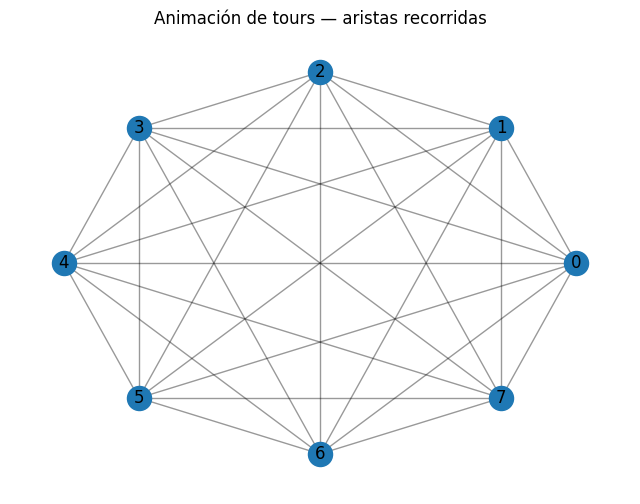

MovieWriter ffmpeg unavailable; using Pillow instead.


Mostrando animación tours_animation_on.gif:


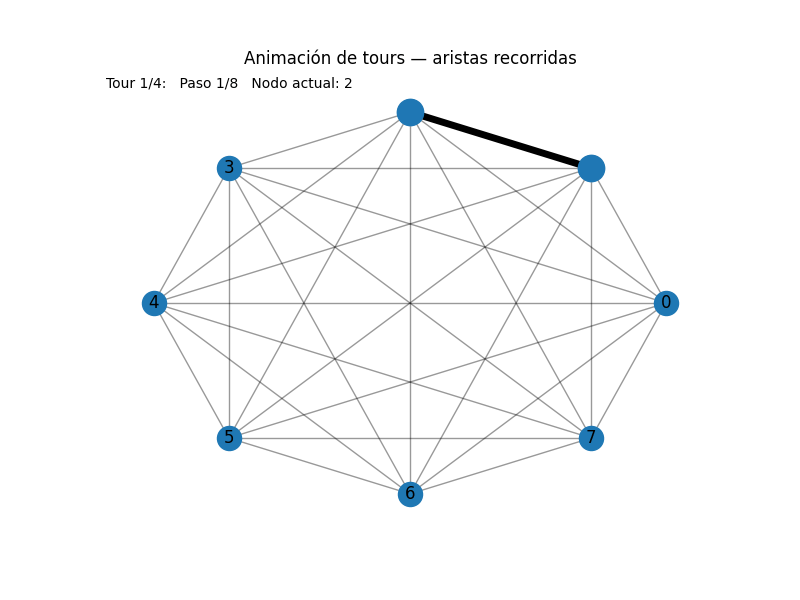

In [17]:
anim_tour(G,[tour_tri,tour_rand,tour_nn,tour_opt])

# Gráficos y Comparaciones

In [18]:
def fila_resultado(tour_nombre, picking, tour_camino, eval_dict):
    items_finales = eval_dict["knapsack_log"][-1][1]

    return {
        "tour_nombre": tour_nombre,
        "picking": picking,
        "tour_camino": tour_camino,
        "items_tomados": items_finales,
        "num_items": len(items_finales),
        "valor_total": eval_dict["total_value"],
        "tiempo_total": eval_dict["total_time"],
        "beneficio_final": eval_dict["final_benefit"],
    }



filas = []

# --- GREEDY ---
filas.append(fila_resultado("Trivial",        "greedy", tour_tri, eval_tri_greedy))
filas.append(fila_resultado("Aleatorio",      "greedy", tour_rand, eval_rand_greedy))
filas.append(fila_resultado("Vecino cercano", "greedy", tour_nn,  eval_nn_greedy))
filas.append(fila_resultado("Óptimo",         "greedy", tour_opt, eval_opt_greedy))

# --- EXCHANGE ---
filas.append(fila_resultado("Trivial",        "exchange", tour_tri, eval_tri_exchange))
filas.append(fila_resultado("Aleatorio",      "exchange", tour_rand, eval_rand_exchange))
filas.append(fila_resultado("Vecino cercano", "exchange", tour_nn,  eval_nn_exchange))
filas.append(fila_resultado("Óptimo",         "exchange", tour_opt, eval_opt_exchange))

# --- POLÍTICA ALL ---
# filas.append(fila_resultado("Trivial",        "all", eval_tri_all))
# filas.append(fila_resultado("Aleatorio",      "all", eval_rand_all))
# filas.append(fila_resultado("Vecino cercano", "all", eval_nn_all))
# filas.append(fila_resultado("Óptimo",         "all", eval_opt_all))

df_res = pd.DataFrame(filas)
df_res


,tour_nombre,picking,tour_camino,items_tomados,num_items,valor_total,tiempo_total,beneficio_final
0,Trivial,greedy,"[1, 2, 3, 4, 5, 6, 7, 0]","[3, 8]",2,75.0,257.425193,-182.425193
1,Aleatorio,greedy,"[1, 7, 0, 3, 5, 4, 2, 6]","[0, 7, 8]",3,142.0,335.642173,-193.642173
2,Vecino cercano,greedy,"[1, 2, 7, 5, 3, 4, 0, 6]","[5, 7, 8]",3,130.0,158.210804,-28.210804
3,Óptimo,greedy,"[1, 6, 2, 7, 5, 3, 4, 0]","[5, 7, 8]",3,130.0,129.282868,0.717132
4,Trivial,exchange,"[1, 2, 3, 4, 5, 6, 7, 0]","[0, 7, 9]",3,186.0,243.509732,-57.509732
5,Aleatorio,exchange,"[1, 7, 0, 3, 5, 4, 2, 6]","[0, 7, 9]",3,186.0,218.674391,-32.674391
6,Vecino cercano,exchange,"[1, 2, 7, 5, 3, 4, 0, 6]","[0, 7, 9]",3,186.0,171.092583,14.907417
7,Óptimo,exchange,"[1, 6, 2, 7, 5, 3, 4, 0]","[0, 7, 9]",3,186.0,146.333698,39.666302


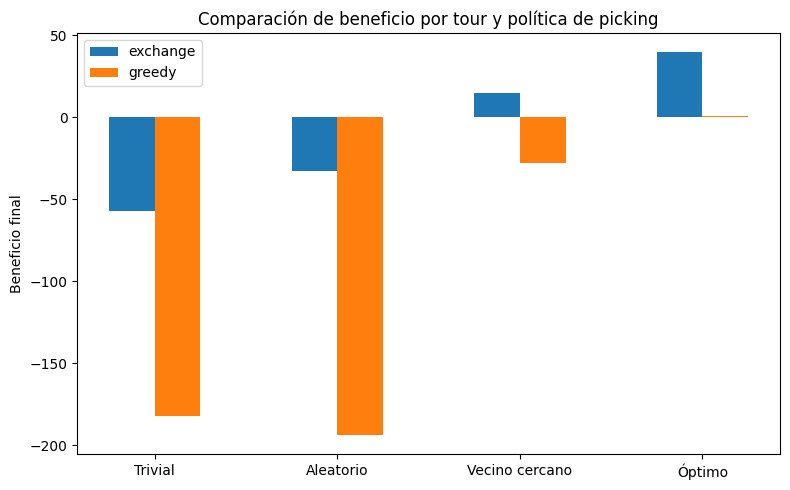

In [19]:
# ordenar tours en un orden fijo
orden_tours = ["Trivial", "Aleatorio", "Vecino cercano", "Óptimo"]
df_res["tour_nombre"] = pd.Categorical(df_res["tour_nombre"], categories=orden_tours, ordered=True)

# gráfico: beneficio vs tour, separado por política
plt.figure(figsize=(8, 5))
for i, pol in enumerate(sorted(df_res["picking"].unique())):
    sub = df_res[df_res["picking"] == pol].sort_values("tour_nombre")
    x = range(len(sub))
    desplazamiento = (i - (len(df_res["picking"].unique())-1)/2)*0.25
    plt.bar([xx + desplazamiento for xx in x],
            sub["beneficio_final"],
            width=0.25,
            label=pol)

plt.xticks(range(len(orden_tours)), orden_tours)
plt.ylabel("Beneficio final")
plt.title("Comparación de beneficio por tour y política de picking")
plt.legend()
plt.tight_layout()
plt.show()


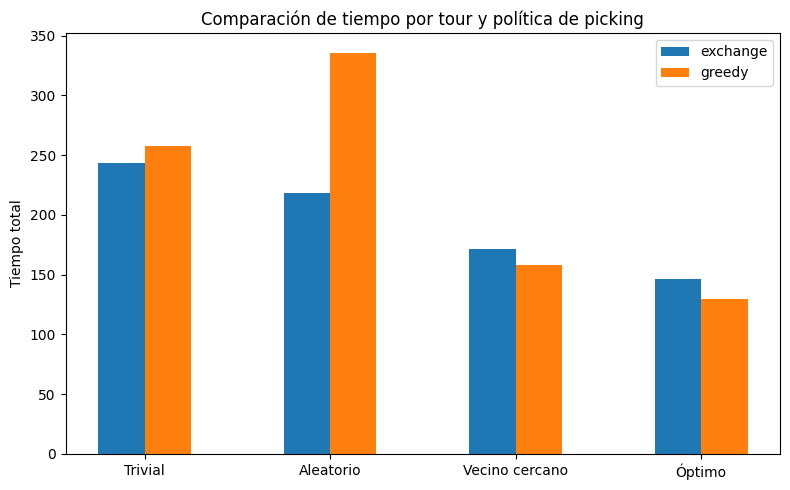

In [20]:
plt.figure(figsize=(8, 5))
for i, pol in enumerate(sorted(df_res["picking"].unique())):
    sub = df_res[df_res["picking"] == pol].sort_values("tour_nombre")
    x = range(len(sub))
    desplazamiento = (i - (len(df_res["picking"].unique())-1)/2)*0.25
    plt.bar([xx + desplazamiento for xx in x],
            sub["tiempo_total"],
            width=0.25,
            label=pol)

plt.xticks(range(len(orden_tours)), orden_tours)
plt.ylabel("Tiempo total")
plt.title("Comparación de tiempo por tour y política de picking")
plt.legend()
plt.tight_layout()
plt.show()


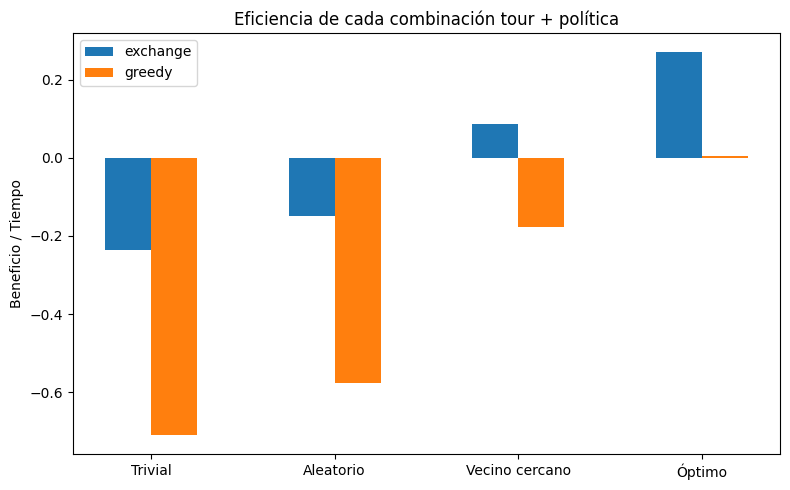

In [21]:
df_res["beneficio_por_tiempo"] = df_res["beneficio_final"] / df_res["tiempo_total"]

plt.figure(figsize=(8, 5))
for i, pol in enumerate(sorted(df_res["picking"].unique())):
    sub = df_res[df_res["picking"] == pol].sort_values("tour_nombre")
    x = range(len(sub))
    desplazamiento = (i - (len(df_res["picking"].unique())-1)/2)*0.25
    plt.bar([xx + desplazamiento for xx in x],
            sub["beneficio_por_tiempo"],
            width=0.25,
            label=pol)

plt.xticks(range(len(orden_tours)), orden_tours)
plt.ylabel("Beneficio / Tiempo")
plt.title("Eficiencia de cada combinación tour + política")
plt.legend()
plt.tight_layout()
plt.show()
